# Clarke's experiment numerical circuit simulation for the full boxes

## Context

In this notebook we simulate Clarke's experiment (https://doi.org/10.1103/PhysRevA.63.040305) for unambiguous discrimination of single-photon polarization states with all 5 paths considered. For this purpose we use the *strawberry fields* package. We simulate the experiment for the three boxes.

## Output

- Numerical output photon distributions for the three boxes

In [1]:
import strawberryfields as sf
from strawberryfields.ops import *

import numpy as np
from numpy import pi, sqrt

import matplotlib.pyplot as plt

# set the random seed
np.random.seed(42)

In [2]:
#========= Simulation parameters ============

n_paths = 4
n_modes = n_paths*2
cutoff_dim = 3
N = 100 # half-number of photons per box
alfa = pi/8
opt_alfa = np.arcsin(np.tan(alfa))/2

#======== Initial State Preparation ==========

# Vacuum State Array
VacuumState = np.zeros([cutoff_dim] * n_modes, dtype='complex')

# One-photon maximum entropy state in path 1
"""
MaxMixedState = np.zeros([cutoff_dim,cutoff_dim] * n_modes, dtype='complex')
MaxMixedState[1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0] = 1/2
MaxMixedState[0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0] = 1/2

MaxMixedState = DensityMatrix(MaxMixedState)
"""
#============ Gates' Construction =============

PBS = Interferometer(np.array([[0,1],[-1,0]]))

def HWP(angle):
    x = np.cos(2*angle)
    y = np.sin(2*angle)
    return Interferometer(np.array([[x,y],[y,-x]]))

QWPV = Interferometer(np.exp(1j*pi/4)*np.array([[1,0],[0,-1j]]))
QWPH = Interferometer(np.exp(-1j*pi/4)*np.array([[1,0],[0,1j]]))

In [3]:
# 2-qubit input state generator
# input photon goes through path 1 in state defined by theta1 and phi1
# ancilla photon goes through path "path" in state defined by theta2 and phi2
def TwoQubitStateIn(theta1, phi1, theta2 = 0., phi2 = 0., path = 3):
    State = np.copy(VacuumState)
    
    if path == 2:
        State[1,0,1,0,0,0,0,0] = np.cos(theta1/2)*np.cos(theta2/2)
        State[1,0,0,1,0,0,0,0] = np.cos(theta1/2)*np.sin(theta2/2)*np.exp(1j*phi2)
        State[0,1,1,0,0,0,0,0] = np.sin(theta1/2)*np.exp(1j*phi1)*np.cos(theta2/2)
        State[0,1,0,1,0,0,0,0] = np.sin(theta1/2)*np.exp(1j*phi1)*np.sin(theta2/2)*np.exp(1j*phi2)
    if path == 3:
        State[1,0,0,0,1,0,0,0] = np.cos(theta1/2)*np.cos(theta2/2)
        State[1,0,0,0,0,1,0,0] = np.cos(theta1/2)*np.sin(theta2/2)*np.exp(1j*phi2)
        State[0,1,0,0,1,0,0,0] = np.sin(theta1/2)*np.exp(1j*phi1)*np.cos(theta2/2)
        State[0,1,0,0,0,1,0,0] = np.sin(theta1/2)*np.exp(1j*phi1)*np.sin(theta2/2)*np.exp(1j*phi2)
    if path == 4:
        State[1,0,0,0,0,0,1,0] = np.cos(theta1/2)*np.cos(theta2/2)
        State[1,0,0,0,0,0,0,1] = np.cos(theta1/2)*np.sin(theta2/2)*np.exp(1j*phi2)
        State[0,1,0,0,0,0,1,0] = np.sin(theta1/2)*np.exp(1j*phi1)*np.cos(theta2/2)
        State[0,1,0,0,0,0,0,1] = np.sin(theta1/2)*np.exp(1j*phi1)*np.sin(theta2/2)*np.exp(1j*phi2)
    
    return State

def SingleQubitStateIn(theta1, phi1, path = 1):
    State = np.copy(VacuumState)
    
    if path == 1:
        State[1,0,0,0,0,0,0,0] = np.cos(theta1/2)
        State[0,1,0,0,0,0,0,0] = np.sin(theta1/2)*np.exp(1j*phi1)
    if path == 2:
        State[0,0,1,0,0,0,0,0] = np.cos(theta1/2)
        State[0,0,0,1,0,0,0,0] = np.sin(theta1/2)*np.exp(1j*phi1)
    if path == 3:
        State[0,0,0,0,1,0,0,0] = np.cos(theta1/2)
        State[0,0,0,0,0,1,0,0] = np.sin(theta1/2)*np.exp(1j*phi1)
    if path == 4:
        State[0,0,0,0,0,0,1,0] = np.cos(theta1/2)
        State[0,0,0,0,0,0,0,1] = np.sin(theta1/2)*np.exp(1j*phi1)
    
    return State

StateDict = {
    "H" : SingleQubitStateIn(0., 0.),
    "V" : SingleQubitStateIn(pi, 0.),
    "D" : SingleQubitStateIn(pi/2, 0.),
    "A" : SingleQubitStateIn(pi/2, pi),
    "L" : SingleQubitStateIn(pi/2, pi/2),
    "R" : SingleQubitStateIn(pi/2,-pi/2)
}


In [4]:
# Angles for the HWPs
a1 = opt_alfa
a2 = opt_alfa - pi/2
a3 = pi/4
a4 = pi/4
a5 = pi/8
a6 = pi/8

In [15]:
#=========== Circuit construction (for pure states) ============

PureStateProg = sf.Program(n_modes)
InitialState = PureStateProg.params('InitialState')

with PureStateProg.context as q:
    # prepare initial state
    Ket(InitialState) | q

    # apply gates
    QWPV | (q[0], q[1])
    HWP(alfa/2) | (q[0], q[1])
    PBS | (q[1], q[5]) # PBS1
    HWP(a1) | (q[0], q[1]) # HWP1
    HWP(a2) | (q[4], q[5]) # HWP2
    PBS | (q[1], q[7]) # PBS2
    PBS | (q[3], q[5]) # PBS3
    HWP(a3) | (q[2] , q[3]) # HWP3
    HWP(-a4) | (q[6] , q[7]) # HWP3
    PBS | (q[3], q[7]) # PBS4
    HWP(a5) | (q[2], q[3]) # HWP5
    HWP(-a6) | (q[6], q[7]) # HWP6

    # measure
    MeasureFock() | q

eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim})

# Box A Simulation

In [16]:
photons = np.array(["H"]*N + ["V"]*N)
np.random.shuffle(photons)

samplesA = []

for s in photons:
    init_state = StateDict[s]
    result = eng.run(PureStateProg, args={'InitialState': init_state})
    samplesA.append(str(result.samples[0]))

labelsA, countsA = np.unique(samplesA,return_counts=True)

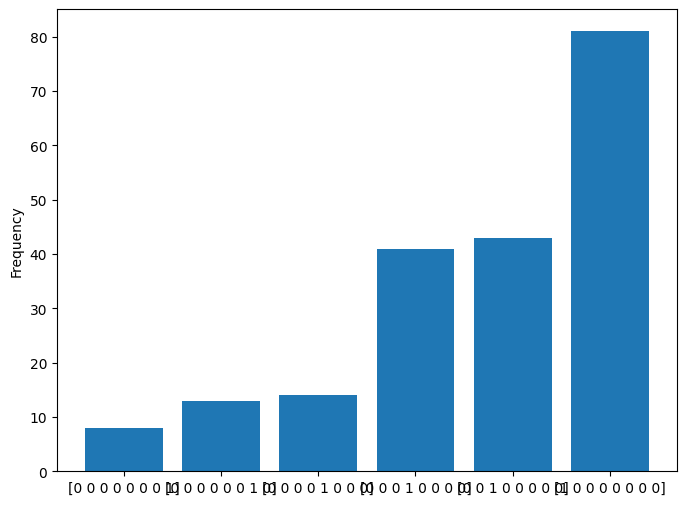

In [17]:
plt.figure(figsize=(8,6))
ticksA = range(len(countsA))
plt.bar(ticksA,countsA, align='center')
plt.xticks(ticksA, labelsA)
plt.ylabel("Frequency")
plt.show()

# Box B Simulation

In [18]:
photons = np.array(["L"]*N + ["R"]*N)
np.random.shuffle(photons)

samplesB = []

for s in photons:
    init_state = StateDict[s]
    result = eng.run(PureStateProg, args={'InitialState': init_state})
    samplesB.append(str(result.samples[0]))
    
labelsB, countsB = np.unique(samplesB,return_counts=True)

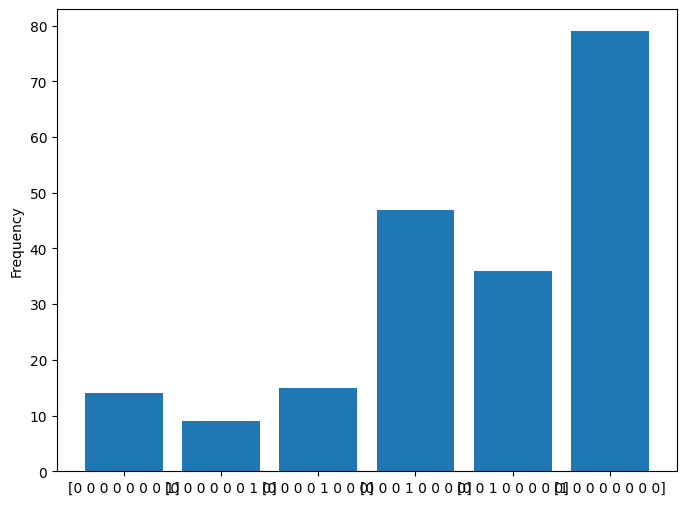

In [19]:
plt.figure(figsize=(8,6))
ticksB = range(len(countsB))
plt.bar(ticksB,countsB, align='center')
plt.xticks(ticksB, labelsB)
plt.ylabel("Frequency")
plt.show()

# Box C Simulation

In [187]:
samplesC = []

for s in photons:
    result = eng.run(MixedStateProg)
    samplesC.append(str(result.samples[0]))

labelsC, countsC = np.unique(samplesC,return_counts=True)

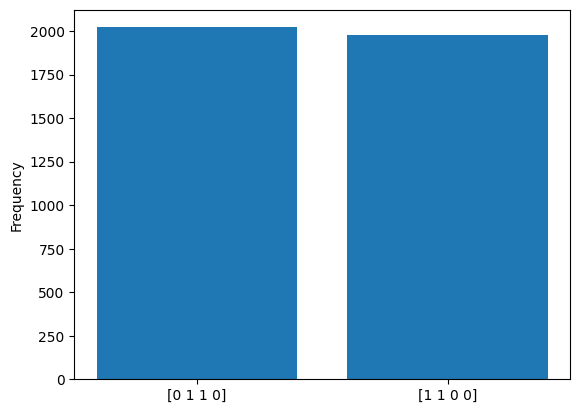

In [188]:
plt.figure()
ticksC = range(len(countsC))
plt.bar(ticksC,countsC, align='center')
plt.xticks(ticksC, labelsC)
plt.ylabel("Frequency")
plt.show()

# All boxes graphs

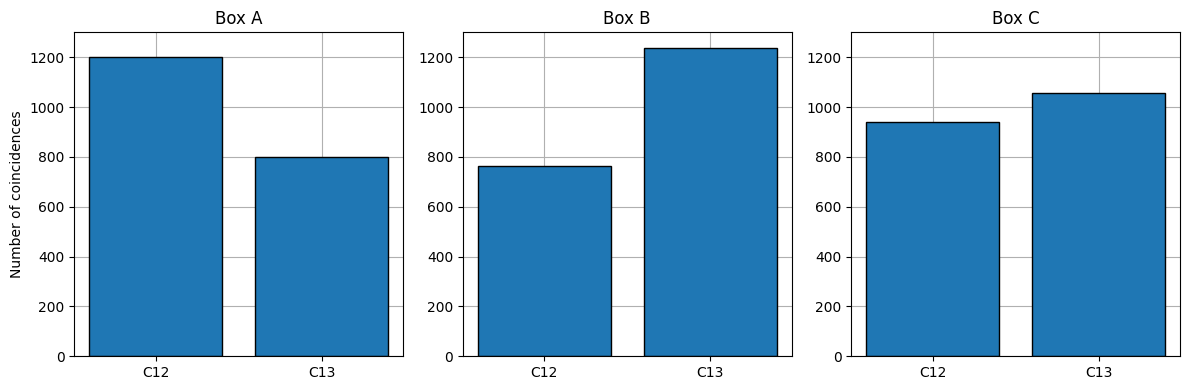

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))
ax[0].set_title("Box A")
ax[0].bar(range(2), freqsA[-2:], ec='k',zorder=2)
ax[0].grid(zorder=1)
ax[0].set_xticks(range(2), ["C12","C13"])
ax[0].set_ylabel("Number of coincidences")
ax[0].set_ylim([0,1300])

ax[1].set_title("Box B")
ax[1].bar(range(2), freqsB[-2:], ec='k',zorder=2)
ax[1].grid(zorder=1)
ax[1].set_xticks(range(2), ["C12","C13"])
ax[1].set_ylim([0,1300])
#ax[1].set_ylabel("Number of coincidences")

ax[2].set_title("Box C")
ax[2].bar(range(2), freqsC[-2:], ec='k',zorder=2)
ax[2].grid(zorder=1)
ax[2].set_xticks(range(2), ["C12","C13"])
ax[2].set_ylim([0,1300])
#ax[2].set_ylabel("Number of coincidences")

plt.tight_layout()
plt.show()